In [1]:
import os
import glob
import yaml
from astropy.table import Table
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import fitsio
import datetime
from desitarget import desi_mask, bgs_mask, mws_mask, contam_mask, targetid_mask, obsconditions
%matplotlib inline

In [2]:
import desisim
import desisurvey
import desimodel.io
import desimodel.footprint

./progress.fits
INFO:progress.py:145:__init__: Loaded progress from /Users/forero/github/SandboxDESI/questions/./progress.fits.


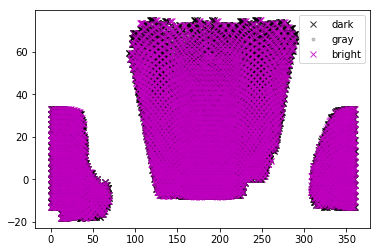

In [29]:
from desisurvey.progress import Progress

os.environ['DESISURVEY_OUTPUT'] = "/Users/forero/github/SandboxDESI/questions/"
progress_filename = "./progress.fits"
print(progress_filename)
if os.path.isfile(progress_filename):
    exposures_filename = "./exposures.fits"
    Progress(restore=progress_filename).get_exposures().write(exposures_filename, overwrite=True)
    
    explist = Table.read(exposures_filename)

    # separate the exposures for dark and bright programs
    isbright = explist['PASS'] > 4 
    isgray = explist['PASS'] == 4
    isdark = explist['PASS'] < 4
    
    exposurefile_bright = 'all_exposures_bright.fits'
    Table(explist[isbright]).write(exposurefile_bright, overwrite=True)

    exposurefile_dark = 'all_exposures_dark.fits'
    Table(explist[~isbright]).write(exposurefile_dark, overwrite=True)
    
    # Make a simple plot
    plt.plot(explist['RA'][isdark], explist['DEC'][isdark], 'kx', alpha=0.8, label='dark')
    plt.plot(explist['RA'][isgray], explist['DEC'][isgray], 'k.', alpha=0.2, label='gray')
    plt.plot(explist['RA'][isbright], explist['DEC'][isbright], 'mx', alpha=0.8, label='bright')
    plt.legend(loc='upper right')
else:
    print('File is missing')

In [30]:
explist[0:10]

TILEID,PASS,RA,DEC,EBMV,NIGHT,MJD,EXPTIME,SEEING,TRANSPARENCY,AIRMASS,MOONFRAC,MOONALT,MOONSEP,PROGRAM,FLAVOR
,,,,,,,s,arcsec,,,,deg,deg,,
int32,int16,float64,float64,float32,str8,float64,float64,float64,float64,float64,float64,float64,float64,str6,str7
34308,5,345.64,25.37,0.145557,20191201,58819.0583701,686.255885087,0.993969678879,0.965001940727,1.01068331726,0.315489669913,34.1941411183,52.6531193026,BRIGHT,science
23195,4,343.4,30.09,0.0609376,20191201,58819.0677018,789.74873144,0.975707352161,0.898529052734,1.00053691614,0.315489669913,33.1271733079,55.6211758454,GRAY,science
23195,4,343.4,30.09,0.0609376,20191201,58819.0782313,826.022135193,0.975707352161,0.898529052734,1.00053691614,0.315489669913,33.1271733079,55.6211758454,GRAY,science
24146,4,2.51,33.12,0.0472297,20191201,58819.0891806,1224.72159613,0.66363376379,0.369656324387,1.01633892137,0.315489669913,29.846672135,67.7038445611,GRAY,science
24146,4,2.51,33.12,0.0472297,20191201,58819.1047445,1189.80322407,0.66363376379,0.369656324387,1.01633892137,0.315489669913,29.846672135,67.7038445611,GRAY,science
24146,4,2.51,33.12,0.0472297,20191201,58819.1199043,1138.86971046,0.66363376379,0.369656324387,1.01633892137,0.315489669913,29.846672135,67.7038445611,GRAY,science
24651,4,8.37,2.77,0.0206253,20191201,58819.1344745,767.082284822,0.89885789156,0.943982303143,1.14472299318,0.315489669913,20.9472461034,53.6178671792,GRAY,science
24651,4,8.37,2.77,0.0206253,20191201,58819.1447417,676.975494729,0.89885789156,0.943982303143,1.14472299318,0.315489669913,20.9472461034,53.6178671792,GRAY,science


In [44]:
#select a subset of tiles 
small_dark_set = (explist['PASS'] <= 4) & (explist['RA']>140) & (explist['RA']<160) & (explist['DEC']<20) & (explist['DEC']>0)
exposurefile_dark = 'subset_exposures_dark.fits'
Table(explist[small_dark_set]).write(exposurefile_dark, overwrite=True)

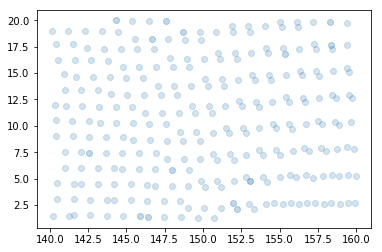

In [45]:
plt.scatter(explist['RA'][small_dark_set], explist['DEC'][small_dark_set], alpha=0.1, label='dark')

In [166]:
tiles = desimodel.io.load_tiles()
tilefile_dark = 'subset_tiles_dark.fits'
xtiles = tiles[np.in1d(tiles['TILEID'], explist['TILEID'][small_dark_set])]
Table(xtiles).write(tilefile_dark, overwrite=True)


16071


In [51]:
def compute_fiberassign_dates(exposurefile, outputfile):
    """
    Computes the dates to read fiberassign from the data in a 'exposures' files.
    
    Args:
        exposurefile (str):
        Name of the file with 'exposures' data
    Return:
        fiberassign_dates_run (list):
        List of string dates where fiberassign should be run.
    """
    desisurvey_path = os.getenv('DESISURVEY_OUTPUT')
    exposures = Table.read(exposurefile)
    expdates = []
    for n in exposures['NIGHT']:
        a = datetime.datetime.strptime(n, "%Y%m%d")
        expdates.append(a.date())
    expdates = np.array(expdates)

    # compute the dates for fiberassign
    progress = Table.read(os.path.join(desisurvey_path,'progress.fits'))
    fiberassign_dates = np.sort(list(set(progress['available'])))
    fiberassign_dates = fiberassign_dates[fiberassign_dates>0]
    
    #load the first date of the survey
    survey_config = os.path.join(desisurvey_path,'config.yaml')
    with open(survey_config, 'r') as pfile:
        params = yaml.load(pfile)
    pfile.close()
    first_day = params['first_day']
    last_day = params['last_day']
 #   print(first_day, last_day)
    
    #compute the dates to run fiberassign to be sure that there is at least one exposure there
    fiberassign_dates_run = []
    one_day = datetime.timedelta(days=1)
    initial_day = first_day 
    for d in fiberassign_dates:
        final_day = first_day + d * one_day
        ii = (expdates > initial_day) & (expdates<=final_day)
        n_in = np.count_nonzero(ii)
        if n_in>0:
#            print(initial_day, final_day, n_in)
            fiberassign_dates_run.append(initial_day.strftime("%Y-%m-%d"))
            initial_day = final_day
    f = open(outputfile, 'w')
    for d in fiberassign_dates_run:
        f.write(d+"\n")
    f.close()

In [52]:
compute_fiberassign_dates("./subset_exposures_dark.fits", "subset_fiberassign_dates.txt")

# Read and process the results

## Fiber efficiency on individual tiles

In [14]:
def tile_efficiency(datapath="../data/ELGquicksurvey/high/"):
    alltilefiles = glob.glob(datapath+"/*/fiberassign/tile*")
    n_tiles = len(alltilefiles)
    efficiency = np.ones(n_tiles)
    print(n_tiles)
    for i in range(n_tiles):
        tilefile = alltilefiles[i]
        obstargets = Table.read(tilefile, hdu=1)
        callib = obstargets['MWS_TARGET']!=0
        n_callib = np.count_nonzero(callib)
        n_gal = np.count_nonzero(~callib)
        efficiency[i]  = n_gal/(n_callib + n_gal)
    return efficiency

In [15]:
eff_high = tile_efficiency(datapath="../data/ELGquicksurvey/high/")

266


In [16]:
eff_low = tile_efficiency(datapath="../data/ELGquicksurvey/low/")

266


In [17]:
eff_mid = tile_efficiency(datapath="../data/ELGquicksurvey/mid/")

266


(0.0, 1.0)

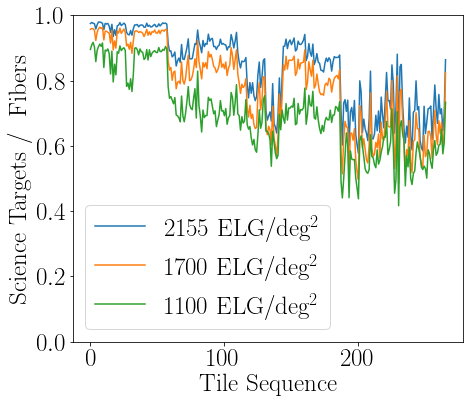

In [18]:
fig = plt.figure(1, figsize=(7,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=25)
plt.plot(eff_high, label='2155 ELG/deg$^2$')
plt.plot(eff_mid, label='1700 ELG/deg$^2$')
plt.plot(eff_low, label='1100 ELG/deg$^2$')
plt.xlabel("Tile Sequence")
plt.ylabel("# Science Targets / # Fibers")
plt.legend(loc=3)
plt.ylim([0.0,1.0])

(0.6, 1.0)

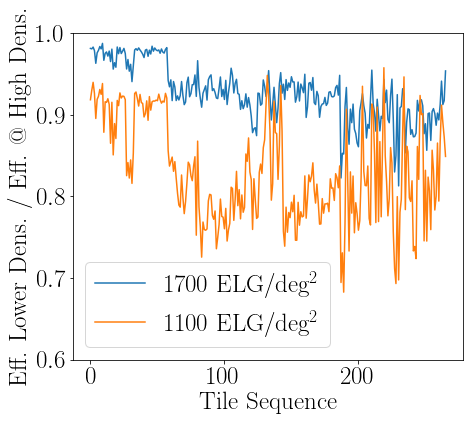

In [19]:
fig = plt.figure(1, figsize=(7,6))
plt.rc('text', usetex=True,)
plt.rc('font', family='serif', size=25)
plt.plot(eff_mid/eff_high, label='1700 ELG/deg$^2$')
plt.plot(eff_low/eff_high, label='1100 ELG/deg$^2$')

plt.xlabel('Tile Sequence')
plt.ylabel('Eff. Lower Dens. / Eff. @ High Dens.')
plt.legend(loc=0)
plt.ylim([0.6,1.0])

In [ ]:
## global ELG efficiency

In [ ]:
def tile_efficiency(datapath="../data/ELGquicksurvey/high/"):
    mtl_file = os.path.join(datapath, "0", "mtl.fits")
    zcat_file = os.path.join(datapath, "4", "zcat.fits")
